In [1]:
# 1. Mount Google Drive and extract dataset
from google.colab import drive
import zipfile

drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/butterfly_dataset.zip"
extract_path = "/content/butterfly_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)


Mounted at /content/drive
✅ Dataset extracted to: /content/butterfly_data


In [3]:
# 2. Organize training and testing images into subfolders by label
import pandas as pd
import shutil
from tqdm import tqdm
import os
def organize_images_by_class(csv_path, image_dir):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.lower()  # Lowercase all column names
    for _, row in tqdm(df.iterrows(), total=len(df)):
        filename = row['filename']
        label = row['label']  # Safe after lowercase
        src = os.path.join(image_dir, filename)
        dst_dir = os.path.join(image_dir, label)
        os.makedirs(dst_dir, exist_ok=True)
        dst = os.path.join(dst_dir, filename)
        if os.path.exists(src):
            shutil.move(src, dst)
        else:
            print(f"❌ Missing file: {filename}")





In [4]:
# 3. Prepare image data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_labels = list(train_gen.class_indices.keys())
print("🦋 Classes:", class_labels)


Found 5225 images belonging to 75 classes.
Found 1274 images belonging to 75 classes.
Found 0 images belonging to 0 classes.
🦋 Classes: ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BECKERS WHITE', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREY HAIRSTREAK', 'INDRA SWALLOW', 'IPHICLUS SISTER', 'JULIA', 'LARGE MARBLE', 'MALACHITE', 'MANGROVE SKIPPER', 'MESTRA', 'METALMARK', 'MILBERTS TORTOISESHELL', 'MONARCH', 'MOURNING CLOAK', 'ORANGE OAKLEAF', 'ORANGE TIP', 'ORCHARD SWALLOW', 'PAINTED LADY', 'PA

In [5]:
# 4. Build and compile MobileNetV2 model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,431,627 (9.28 MB)

 Trainable params: 173,643 (678.29 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# 5. Train the model
EPOCHS = 10

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2783 - loss: 3.2146

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.2795 - loss: 3.2090 - val_accuracy: 0.7520 - val_loss: 1.0354
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.7951 - loss: 0.8417 - val_accuracy: 0.7991 - val_loss: 0.7056
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.8940 - loss: 0.4615 - val_accuracy: 0.8312 - val_loss: 0.5948
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.9421 - loss: 0.2777 - val_accuracy: 0.8501 - val_loss: 0.5382
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.9532 - loss: 0.2213 - val_accuracy: 0.8438 - val_loss: 0.5047
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.9743 - loss: 0.1443 - val_accuracy: 0.8564 - val_loss: 0.4725
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9798 - loss: 0.1137 - val_accuracy: 0.8666 - val_loss: 0.4545
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.9880 - loss: 0.0887 - val_accuracy: 0.862

In [7]:
# 6. Predict and visualize a few test images
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_image(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    predicted_class = class_labels[np.argmax(pred)]
    confidence = np.max(pred)

    return predicted_class, confidence, img

# Predict first 10 test images
test_images_dir = "/content/butterfly_data/test"
for subdir in os.listdir(test_images_dir):
    subfolder = os.path.join(test_images_dir, subdir)
    if os.path.isdir(subfolder):
        images = [f for f in os.listdir(subfolder) if f.endswith(('.jpg', '.jpeg', '.png'))]
        for img_name in sorted(images)[:1]:  # Just 1 per class
            img_path = os.path.join(subfolder, img_name)
            pred_class, conf, img = predict_image(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{img_name}\nPrediction: {pred_class} ({conf:.2f})")
            plt.show()


In [8]:
# 7. Save the trained model
model.save("/content/butterfly_species_classifier.h5")
print("✅ Model saved successfully.")


✅ Model saved successfully.


In [9]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/content/butterfly_species_classifier.h5")
print("✅ Model loaded.")


✅ Model loaded.


In [10]:
# This should match your training class order
class_labels = ['species_1', 'species_2', 'species_3', ...]  # Replace with actual class names


In [11]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = (224, 224)

def predict_butterfly(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)

    return predicted_class, confidence, img


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


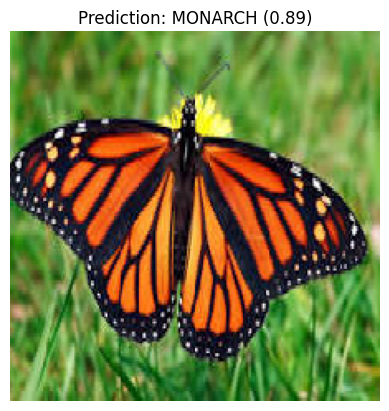

In [15]:
pred_class, conf, img = predict_butterfly("b1.jpeg")

import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {pred_class} ({conf:.2f})")
plt.show()


Saving b2.jpeg to b2.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


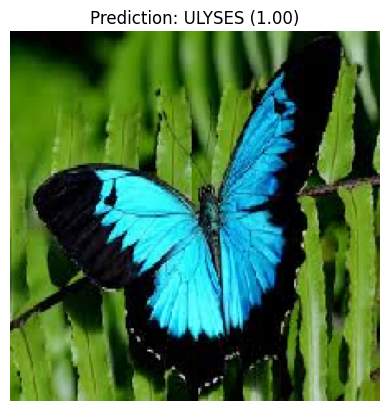

In [17]:
from google.colab import files
uploaded = files.upload()

img_path = list(uploaded.keys())[0]
pred_class, conf, img = predict_butterfly(img_path)

import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {pred_class} ({conf:.2f})")
plt.show()
